# Image processing with tensorflow

This notebook will show how the images in a dataset can be processed using both geometric and colour operations.

It will also present a new way of loading data.

### Refs

TensorFlow addons: https://www.tensorflow.org/addons

command: pip install tensorflow-addons

Loading custom datasets: https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import tensorflow as tf

# this package will be used for the data augmentation operations
import tensorflow_addons as tfa

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

### Settings

In [2]:
data_dir = 'dogsVScats'

IMG_SIZE = 128

### Aux function to show images

In [3]:
def show_images(image_batch, label_batch, rows, columns):
  count = rows* columns  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(count):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

### Prepare dataset

Loading, resizing and batching the dataset is performed with function: image_dataset_from_directory.

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

This function does not allow the normalization of data, so that is performed afterwards using Keras layers.





In [4]:
BATCH_SIZE = 8

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle=True)
 
normalize = tf.keras.layers.Rescaling(1.0/255) 
dataset = dataset.map(lambda x, y: (normalize(x), y))

classNames = np.array(os.listdir(data_dir))


Found 16 files belonging to 2 classes.


## Show images for two batches

Batch size is 8, and the dataset contains only 16 images, so the first two batches are an epoch.

Note that an epoch will not necessarily include all the images in the training set, repeating some of the images. Nevertheless, over a sufficiently large number of epochs all images will be presented to the model roughly an equal amount of times.

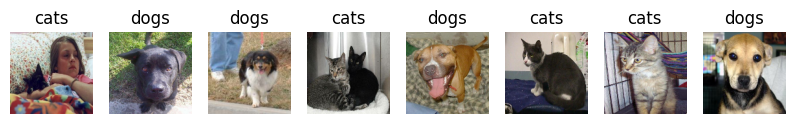

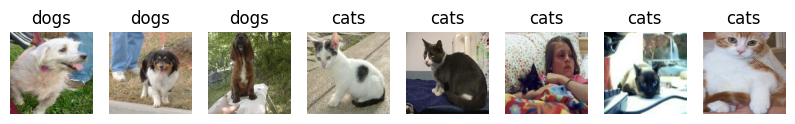

In [5]:

image_batch, label_batch = next(iter(dataset))      
show_images(image_batch, label_batch.numpy(),1,8)

image_batch, label_batch = next(iter(dataset))      
show_images(image_batch, label_batch.numpy(),1,8)



# Performing dynamic data augmentation

With dynamic data augmentation, images from the dataset are processed before being fed into the model. Each batch calls the processing functions and returns potentially a different set of images. The result of applying this function is commonly an image that is close to the original image, for instance with a small rotation, translation, or some color shift.

Since the model is always seeing new images the risk of overfitting is reduced, as the dataset becomes virtually infinite.

Overfitting may occur when the model is sufficiently large to be able to "memorize" the data in the training set. In this scenario, an excellent accuracy may be obtained in the training set, however, that accuracy is not observed in the test or validation sets.

With data augmentation the accuracy on the training set is generally lower than without data augmentation, nevertheless this accuracy reflects better the capacity of the model to generalize, with the accuracies of the test and validation sets becoming closer. Furthermore, the accuracy in a test set of a model which has suffered data augmentation tends to be higher.

Note, however, that biases in the original dataset may still be present in the augmented dataset. For instance, if all images of a particular class are taken in cloudy days, most likely this will also occur in the augmented data set.



### Function to process an image

This is the initial function we shall use for image processing. The function applies some random geometric transformations and some colour operations.

These functions receive the original image and label and output a new image and label. Note that the label may be different from the original label as well. For instance consider the traffic sign for mandatory right turn. By flipping this image horizontally we get a valid image, mandatory left turn, but which belongs to another class.

In [6]:
def process_image(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5) - 0.25
    image = tfa.image.rotate(image, r)
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])
    image = tfa.image.random_hsv_in_yiq(image, 
                    0.4,
                    0.4,1.4,
                    0.4, 1.4)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Creating a dataset with data dynamic data augmentation

To achieve data augmentation we map a function to the dataset

In [7]:

datasetA = dataset.map(process_image)

### Show a batch of the augmented dataset. 

Note that all images are slightly different from the original images

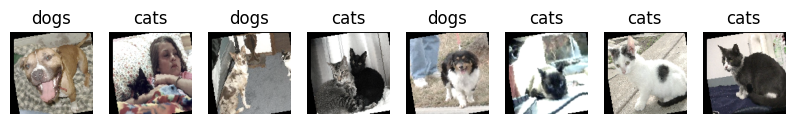

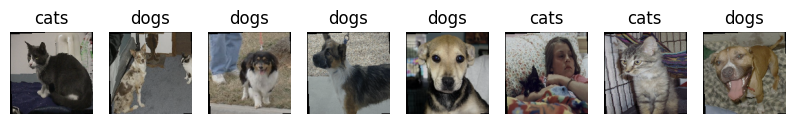

In [8]:
image_batch, label_batch = next(iter(datasetA))      
show_images(image_batch, label_batch.numpy(),1,8)
image_batch, label_batch = next(iter(datasetA))      
show_images(image_batch, label_batch.numpy(),1,8)

In the example above, the transformation parameters are the same for all elements in the batch. To avoid this we must map before we batch. That implies setting batch_size = None in the image_dataset_from_directory function, and batching after we map the processing function.

In [9]:
datasetB = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = None,
    label_mode = 'categorical',
    shuffle=True)
 
normalize = tf.keras.layers.Rescaling(1.0/255) 
datasetB = datasetB.map(lambda x, y: (normalize(x), y))
datasetB = datasetB.map(process_image)
datasetB = datasetB.batch(batch_size=BATCH_SIZE)

Found 16 files belonging to 2 classes.


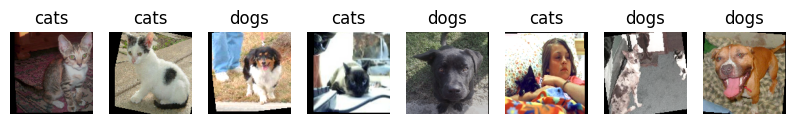

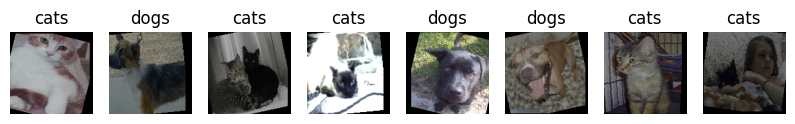

In [10]:
image_batch, label_batch = next(iter(datasetB))      
show_images(image_batch, label_batch.numpy(),1,8)
image_batch, label_batch = next(iter(datasetB))      
show_images(image_batch, label_batch.numpy(),1,8)

## Amplifying the dataset

In some circumstances it may prove more beneficial to create new images by applying different sets of transformation to the same image.

For this purpose we can create a dataset which is the concatenation of two augmented datasets, each with is processing function.

### Define simpler functions for data augmentation

Defining multiple functions for data augmentation provides extended control on how the data augmentation is processed. Furthermore, it allows the concatenation of several datasets.

In [11]:
def process_image_trans(image, label):
    
    rx = 40#tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = 40#tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])

    return image, label

def process_image_rot(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5, dtype=tf.dtypes.float32) - 0.25
    image = tfa.image.rotate(image, r)
    image = tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Create a dataset with twice the number of images

In this new dataset, a subset is translated, the other is rotated.

First create a dataset with the images on the folders. When creating the dataset we set batch_size = None. This is because we want to concatenate the images of the two datasets, not their batches.

As is the concatenated data set will have 32 images which can be shuffled and then batched. This results in batches where images of both individual datasets will be present.


In [12]:
datasetC = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = None,
    label_mode = 'categorical',
    shuffle = False)
 
normalize = tf.keras.layers.Rescaling(1.0/255) 
datasetC = datasetC.map(lambda x, y: (normalize(x), y))


Found 16 files belonging to 2 classes.


Concatenate two datasets, where each takes its processing function. THen shuffle and batch the dataset

In [13]:
BATCH_SIZE = 8

datasetD = datasetC.map(process_image_trans)
datasetD = datasetC.concatenate(datasetC.map(process_image_rot))

datasetD = datasetD.shuffle(32)
datasetD = datasetD.batch(batch_size = BATCH_SIZE)


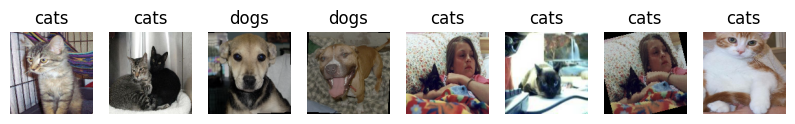

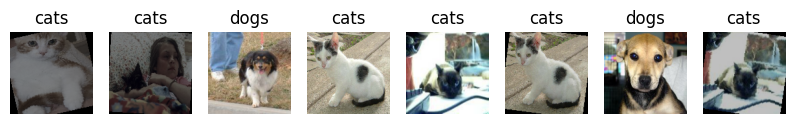

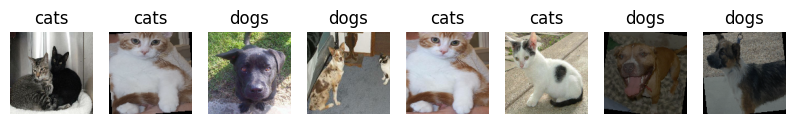

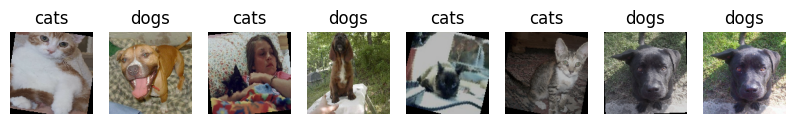

In [14]:
image_batch, label_batch = next(iter(datasetD)) 
show_images(image_batch, label_batch.numpy(),1,8)
image_batch, label_batch = next(iter(datasetD))      
show_images(image_batch, label_batch.numpy(),1,8)
image_batch, label_batch = next(iter(datasetD))      
show_images(image_batch, label_batch.numpy(),1,8)
image_batch, label_batch = next(iter(datasetD))      
show_images(image_batch, label_batch.numpy(),1,8)
